# Model comparison

In [110]:
import os
import sys
import pandas as pd
import re
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Gupta GHMI performance for comparison

Gupta and colleagues test their index on a dataset of size 679, of which 118 are healthy and 561 are unhealthy. They have 91 true positives, 27 false negatives, 167 false positives, and 394 true negatives. 

In [111]:
# load data
root = Path.cwd().parents[1]

# Given values from Gupta paper
TP = 91
FN = 27
FP = 167
TN = 394

# Calculating metrics for class 1
precision_1 = TP / (TP + FP)
recall_1 = TP / (TP + FN)
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
support_1 = TP + FN

# Calculating metrics for class 0
precision_0 = TN / (TN + FN)
recall_0 = TN / (TN + FP)
f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
support_0 = TN + FP

# Calculating overall accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Macro average of precision, recall, f1-score, and support
macro_precision = (precision_0 + precision_1) / 2
macro_recall = (recall_0 + recall_1) / 2
macro_f1_score = (f1_score_0 + f1_score_1) / 2
macro_support = (support_0 + support_1) / 2

# Weighted average of precision, recall, f1-score, and support
total_support = support_0 + support_1
weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_support
weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_support
weighted_f1_score = (f1_score_0 * support_0 + f1_score_1 * support_1) / total_support
weighted_support = total_support

# specify number of decimals
ndecimals = 3

results = {
    "Overall accuracy": round(accuracy, ndecimals),
    "Class 0": {
        "Precision": round(precision_0, ndecimals),
        "Recall": round(recall_0, ndecimals),
        "F1-score": round(f1_score_0, ndecimals),
        "Support": support_0
    },
    "Class 1": {
        "Precision": round(precision_1, ndecimals),
        "Recall": round(recall_1, ndecimals),
        "F1-score": round(f1_score_1, ndecimals),
        "Support": support_1
    },
    "Macro average": {
        "Precision": round(macro_precision, ndecimals),
        "Recall": round(macro_recall, ndecimals),
        "F1-score": round(macro_f1_score, ndecimals),
        "Support": macro_support
    },
    "Weighted average": {
        "Precision": round(weighted_precision, ndecimals),
        "Recall": round(weighted_recall, ndecimals),
        "F1-score": round(weighted_f1_score, ndecimals),
        "Support": weighted_support
    }
}

import pandas as pd

# Converting the results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df


# Preparing content for text file
text_content = f"""
GHMI - test - Accuracy: {results['Overall accuracy']}
Classification Report:
0: {{'precision': {results['Class 0']['Precision']}, 'recall': {results['Class 0']['Recall']}, 'f1-score': {results['Class 0']['F1-score']}, 'support': {results['Class 0']['Support']}}}
1: {{'precision': {results['Class 1']['Precision']}, 'recall': {results['Class 1']['Recall']}, 'f1-score': {results['Class 1']['F1-score']}, 'support': {results['Class 1']['Support']}}}
accuracy: {results['Overall accuracy']}
macro avg: {{'precision': {results['Macro average']['Precision']}, 'recall': {results['Macro average']['Recall']}, 'f1-score': {results['Macro average']['F1-score']}, 'support': {results['Macro average']['Support']}}}
weighted avg: {{'precision': {results['Weighted average']['Precision']}, 'recall': {results['Weighted average']['Recall']}, 'f1-score': {results['Weighted average']['F1-score']}, 'support': {results['Weighted average']['Support']}}}
"""


file_path = root / 'results/model_reports/GMHI/GMHI_results.txt'
file_path.parent.mkdir(parents=True, exist_ok=True)
file_path.write_text(text_content)

395

## 0. Read in model reports & ROC AUC data from test splits

In [112]:
# define root dir
root = Path.cwd().parents[1]
results_root = root / "results/model_reports/"

# list all subdirectories in the results directory
subdirs = [x for x in results_root.iterdir() if x.is_dir()]
subdirs 

[PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/CLR_PCA_LowAbFilt_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/r

In [113]:
# initialize an empty list to store DataFrames
dfs = []

# loop through each subdirectory and read the roc_auc_scores.txt file
for subdir in subdirs:
    file_path = subdir / 'roc_auc_scores.txt'
    if file_path.exists():
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Initialize lists to store the data
        models = []
        rocaucs = []
        subdir_names = []
        
        # Parse each line
        for line in lines:
            model, rocauc = line.split(': ROC AUC = ')
            models.append(model.strip())
            rocaucs.append(float(rocauc.strip()))
            subdir_names.append(subdir.name)  # Add the subdir name
        
        # Create a DataFrame for the current file
        data = {'Model': models, 'ROCAUC': rocaucs, 'Directory': subdir_names}
        df = pd.DataFrame(data)
        
        # Add the DataFrame to the list
        dfs.append(df)
        
# concatenate all DataFrames
rocauc_df = pd.concat(dfs, ignore_index=True)

# sort the ROCAUC from high to low
rocauc_df = rocauc_df.sort_values(by='ROCAUC', ascending=False)
rocauc_df


,Model,ROCAUC,Directory
113,KNN_Optimized,0.88,CLR_PCA_LowAbFilt
109,XGBoost_Optimized,0.86,CLR_PCA_LowAbFilt
108,XGBoost_Basic,0.86,CLR_PCA_LowAbFilt
110,Neural_Network,0.85,CLR_PCA_LowAbFilt
106,Random_Forest_Basic,0.85,CLR_PCA_LowAbFilt
...,...,...,...
74,Deterministic,0.50,baseline
83,Majority_Class_Classifier,0.50,baseline
84,Chance_Class_Classifier,0.50,baseline
93,Majority_Class_Classifier,0.50,50SPC_CLR_smote


In [114]:
# Define the root directory
root = Path.cwd().parents[1]
results_root = root / "results/model_reports/"

# Function to extract data
def extract_metrics(section):
    metrics = {}
    accuracy = section[1]
    report = section[2]

    # Extract accuracy
    metrics['Accuracy'] = float(accuracy)
    
    # Extract individual class metrics
    class_metrics = re.findall(r'(\d.\d): \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    for metric in class_metrics:
        class_id = metric[0]
        metrics[f'Class_{class_id}_precision'] = float(metric[1])
        metrics[f'Class_{class_id}_recall'] = float(metric[2])
        metrics[f'Class_{class_id}_f1-score'] = float(metric[3])
        metrics[f'Class_{class_id}_support'] = float(metric[4])
    
    # Extract macro avg metrics
    macro_avg = re.search(r'macro avg: \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    metrics['macro_avg_precision'] = float(macro_avg.group(1))
    metrics['macro_avg_recall'] = float(macro_avg.group(2))
    metrics['macro_avg_f1-score'] = float(macro_avg.group(3))
    metrics['macro_avg_support'] = float(macro_avg.group(4))
    
    # Extract weighted avg metrics
    weighted_avg = re.search(r'weighted avg: \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    metrics['weighted_avg_precision'] = float(weighted_avg.group(1))
    metrics['weighted_avg_recall'] = float(weighted_avg.group(2))
    metrics['weighted_avg_f1-score'] = float(weighted_avg.group(3))
    metrics['weighted_avg_support'] = float(weighted_avg.group(4))
    
    return metrics

# List to store all data
all_data = []

In [115]:
# list all files in results_root
files = list(results_root.glob('**/*.txt'))
files

[PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Random_Forest_Basic_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Elastic_Net_Logistic_Regression_Best_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Random_Forest_Optimized_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Deterministic_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/XGBoost_Basic_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/XGBoost_Optimized_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/roc_auc_scores.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-2

In [116]:
# iterate over all directories in the results/model_reports directory

# iterate over all subdirs in the results_root regardless of pattern in the name
for results in results_root.glob("*/"):
    # Extract the directory name
    directory_name = results.name
    
    # Iterate over all txt files in the directory
    for txt_file in results.glob("*.txt"):
        # Read the text file
        with open(txt_file, 'r') as file:
            data = file.read()
        
        # Extract the model name from the file path
        model_name = txt_file.stem.replace('_results', '')

        # Generalize the regular expression to split the data into sections
        sections = re.split(r'(\w+) - (\w+) - Accuracy: ([\d.]+)', data)[1:]

        # Process each section and store the results in a list
        for i in range(0, len(sections), 4):
            classifier_name = sections[i]
            split_type = sections[i+1]
            accuracy = sections[i+2]
            section_data = sections[i+3]
            section_metrics = extract_metrics([split_type, accuracy, section_data])
            section_metrics['Split'] = split_type
            section_metrics['Model'] = model_name
            section_metrics['Directory'] = directory_name
            all_data.append(section_metrics)

# Create DataFrame
combined_df = pd.DataFrame(all_data)

# Ensure 'Directory' is the first column, 'Model' is the second column, and 'Split' is the third column
columns = ['Directory', 'Model', 'Split'] + [col for col in combined_df.columns if col not in ['Directory', 'Model', 'Split']]
combined_df = combined_df[columns]

for directory in combined_df['Directory'].unique():
    print(f"Directory: {directory}")

combined_df

Directory: baseline_smote
Directory: 50SPC_undersampled
Directory: 50SPC_CLR
Directory: 50SPC_CLR_undersampled
Directory: baseline_undersampled
Directory: CLR_PCA_LowAbFilt_smote
Directory: 50SPC
Directory: baseline
Directory: 50SPC_CLR_smote
Directory: 50SPC_smote
Directory: CLR_PCA_LowAbFilt
Directory: CLR_PCA_LowAbFilt_undersampled
Directory: GMHI


,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support
0,baseline_smote,Random_Forest_Basic,train,0.814681,0.818966,0.814681,0.814056,8024.0,0.818966,0.814681,0.814056,8024.0
1,baseline_smote,Random_Forest_Basic,val,0.674230,0.643446,0.664286,0.645017,1234.0,0.710838,0.674230,0.685123,1234.0
2,baseline_smote,Random_Forest_Basic,test,0.702593,0.673438,0.698990,0.676413,1234.0,0.739037,0.702593,0.712663,1234.0
3,baseline_smote,Elastic_Net_Logistic_Regression_Best,train,0.688809,0.689821,0.688809,0.688393,8024.0,0.689821,0.688809,0.688393,8024.0
4,baseline_smote,Elastic_Net_Logistic_Regression_Best,val,0.646677,0.619716,0.638475,0.618385,1234.0,0.690164,0.646677,0.659308,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...
353,CLR_PCA_LowAbFilt_undersampled,Neural_Network,test,0.624194,0.599256,0.614504,0.596290,1240.0,0.668849,0.624194,0.637375,1240.0
354,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,train,1.000000,1.000000,1.000000,1.000000,3472.0,1.000000,1.000000,1.000000,3472.0
355,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,val,0.635484,0.628271,0.652260,0.617341,1240.0,0.705731,0.635484,0.650535,1240.0
356,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,test,0.642742,0.631660,0.654315,0.623978,1240.0,0.703541,0.642742,0.656493,1240.0


In [117]:
# Ensure 'Model' is 'Random_Forest_Optimized' where 'Directory' is 'GMHI'
combined_df.loc[combined_df['Directory'] == 'GMHI', 'Model'] = 'Random_Forest_Optimized'

# Verify the changes
combined_df

,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support
0,baseline_smote,Random_Forest_Basic,train,0.814681,0.818966,0.814681,0.814056,8024.0,0.818966,0.814681,0.814056,8024.0
1,baseline_smote,Random_Forest_Basic,val,0.674230,0.643446,0.664286,0.645017,1234.0,0.710838,0.674230,0.685123,1234.0
2,baseline_smote,Random_Forest_Basic,test,0.702593,0.673438,0.698990,0.676413,1234.0,0.739037,0.702593,0.712663,1234.0
3,baseline_smote,Elastic_Net_Logistic_Regression_Best,train,0.688809,0.689821,0.688809,0.688393,8024.0,0.689821,0.688809,0.688393,8024.0
4,baseline_smote,Elastic_Net_Logistic_Regression_Best,val,0.646677,0.619716,0.638475,0.618385,1234.0,0.690164,0.646677,0.659308,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...
353,CLR_PCA_LowAbFilt_undersampled,Neural_Network,test,0.624194,0.599256,0.614504,0.596290,1240.0,0.668849,0.624194,0.637375,1240.0
354,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,train,1.000000,1.000000,1.000000,1.000000,3472.0,1.000000,1.000000,1.000000,3472.0
355,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,val,0.635484,0.628271,0.652260,0.617341,1240.0,0.705731,0.635484,0.650535,1240.0
356,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,test,0.642742,0.631660,0.654315,0.623978,1240.0,0.703541,0.642742,0.656493,1240.0


In [118]:
# Create subset with all test splits
test_splits = combined_df[combined_df['Split'].str.contains('test')]

# Combine test_splits with rocauc_df based on match in Directory and Model
test_eval = pd.merge(test_splits, rocauc_df, on=['Directory', 'Model'], how='left')

# Assign NaN to rows with no ROCAUC value
test_eval['ROCAUC'] = test_eval['ROCAUC'].where(test_eval['ROCAUC'].notna(), np.nan)

# Clean data a bit
filter_out = ['Basic', 'Deterministic', 'Chance_Class_Classifier', 'Majority_Class_Classifier']

# Filter out the rows in which value in 'Model' is exactly 'Logistic_Regression_Best' but doesn't contain the string 'Elastic_net'
test_eval = test_eval[~((test_eval['Model'] == 'Logistic_Regression_Best') & (~test_eval['Model'].str.contains('Elastic_net')))]

pattern = '|'.join(filter_out)
test_eval = test_eval[~test_eval['Model'].str.contains(pattern)]

# Sort the data based on 'macro_avg_recall'
test_eval = test_eval.sort_values(by='macro_avg_recall', ascending=False)

# Round all the numeric columns to 3 decimals
test_eval = test_eval.round(3)

test_eval


,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support,ROCAUC
116,CLR_PCA_LowAbFilt,KNN_Optimized,test,0.828,0.810,0.781,0.792,1234.0,0.824,0.828,0.824,1234.0,0.88
111,CLR_PCA_LowAbFilt,XGBoost_Optimized,test,0.815,0.799,0.757,0.771,1234.0,0.811,0.815,0.808,1234.0,0.86
109,CLR_PCA_LowAbFilt,Random_Forest_Optimized,test,0.815,0.801,0.754,0.770,1234.0,0.811,0.815,0.807,1234.0,0.85
115,CLR_PCA_LowAbFilt,Neural_Network,test,0.801,0.776,0.746,0.757,1234.0,0.795,0.801,0.795,1234.0,0.85
127,GMHI,Random_Forest_Optimized,test,0.714,0.644,0.737,0.643,339.5,0.835,0.714,0.747,679.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,50SPC,KNN_Optimized,test,0.652,0.562,0.551,0.552,1234.0,0.626,0.652,0.635,1234.0,0.61
31,50SPC_CLR,Neural_Network,test,0.688,0.580,0.530,0.503,1234.0,0.631,0.688,0.622,1234.0,0.66
24,50SPC_CLR,Elastic_Net_Logistic_Regression_Best,test,0.701,0.629,0.523,0.474,1234.0,0.660,0.701,0.610,1234.0,0.67
65,50SPC,Elastic_Net_Logistic_Regression_Best,test,0.699,0.749,0.505,0.422,1234.0,0.730,0.699,0.580,1234.0,0.64


## 1. Save macro_avg_recall result tables

First I prepare a folder in which I can save the result figs

In [119]:
figs_root = root / "figs/"
figs_root.mkdir(exist_ok=True)

### 1.1 Create result table for data w/o balancing

In [120]:
# print column names in df
print(macro_avg_recall_df.columns)

Index(['Directory', 'RF', 'XGB', 'LogReg', 'KNN', 'NN'], dtype='object', name='Model')


In [121]:
imbal_macro_avg_recall = macro_avg_recall_df

# Remove rows where 'Directory'=='50SPC'
imbal_macro_avg_recall = imbal_macro_avg_recall[imbal_macro_avg_recall['Directory'] != '50SPC']

# Remove columns containing the string 'smote'
imbal_macro_avg_recall = imbal_macro_avg_recall.loc[:, ~imbal_macro_avg_recall.columns.str.contains('smote|GMHI', case=False)]

# Remove rows where any column contains the string 'smote'
imbal_macro_avg_recall = imbal_macro_avg_recall[~imbal_macro_avg_recall.apply(lambda row: row.astype(str).str.contains('smote|undersampled', case=False).any(), axis=1)]

imbal_macro_avg_recall

# replace value '50SPC_CLR' with '50SPC'
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('50SPC_CLR', '50SPC')
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('baseline', 'Baseline')
imbal_macro_avg_recall

# print the column names in imbalanced
for col in imbal_macro_avg_recall.columns:
    print(col)

imbal_macro_avg_recall.to_csv(figs_root / 'imbalanced_macroavg_recall.csv', index=False)

imbal_macro_avg_recall

Directory
RF
XGB
LogReg
KNN
NN


Model,Directory,RF,XGB,LogReg,KNN,NN
1,50SPC,0.560,0.573,0.523,0.557,0.530
6,PCA_LAF,0.754,0.757,0.701,0.781,0.746
9,GMHI,0.737,NaN,NaN,NaN,NaN
10,Baseline,0.648,0.645,0.611,0.628,0.586


### 1.2 Create result table for data w undersampling

In [122]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_macro_avg_recall_df = macro_avg_recall_df[macro_avg_recall_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_macro_avg_recall_df = undersampled_macro_avg_recall_df[undersampled_macro_avg_recall_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('baseline_undersampled', 'Baseline')

# save undersampled as a csv file
undersampled_macro_avg_recall_df.to_csv(figs_root / 'undersampled_macroavg_recall.csv', index=False)
undersampled_macro_avg_recall_df


Model,Directory,RF,XGB,LogReg,KNN,NN
3,50SPC,0.629,0.637,0.618,0.566,0.588
8,PCA_LAF,0.640,0.632,0.617,0.654,0.615
9,GMHI,0.737,NaN,NaN,NaN,NaN
12,Baseline,0.713,0.713,0.690,0.661,0.690


### 1.3 Create result table for data w SMOTE

In [123]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_macro_avg_recall_df = macro_avg_recall_df[macro_avg_recall_df['Directory'].str.contains('smote', na=False)]
smote_macro_avg_recall_df = smote_macro_avg_recall_df[smote_macro_avg_recall_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('baseline_smote', 'Baseline')

smote_macro_avg_recall_df.to_csv(figs_root / 'smote_macroavg_recall.csv', index=False)

smote_macro_avg_recall_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.592,0.612,0.62,0.559,0.590
7,PCA_LAF,0.601,0.629,0.58,0.666,0.600
11,Baseline,0.697,0.704,0.68,0.672,0.687


## 2. Save macro_avg_f1-score result tables

In [124]:
# ---- MAKE THE OVERALL RESULTS DF ---- # 
test_eval_macro_avg_f1 = test_eval[['Directory', 'Model', 'macro_avg_f1-score']]
# restructure the dataframe
test_eval_macro_avg_f1 = test_eval_macro_avg_f1.pivot(index='Directory', columns='Model', values='macro_avg_f1-score').reset_index()
# display the final dataframe
test_eval_macro_avg_f1

macro_avg_f1_df = test_eval_macro_avg_f1.rename(columns={
    'Elastic_Net_Logistic_Regression_Best': 'LogReg',
    'KNN_Optimized': 'KNN',
    'Neural_Network': 'NN',
    'Random_Forest_Optimized': 'RF',
    'XGBoost_Optimized': 'XGB'
})

macro_avg_f1_df = macro_avg_f1_df[['Directory', 'RF', 'XGB','LogReg','KNN','NN']]
# make df a pandas dataframe
macro_avg_f1_df = pd.DataFrame(macro_avg_f1_df)
macro_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
0,50SPC,0.578,0.542,0.422,0.552,0.419
1,50SPC_CLR,0.554,0.572,0.474,0.558,0.503
2,50SPC_CLR_smote,0.592,0.609,0.583,0.550,0.582
3,50SPC_CLR_undersampled,0.573,0.587,0.577,0.525,0.559
4,50SPC_smote,0.605,0.588,0.505,0.557,0.527
5,50SPC_undersampled,0.568,0.592,0.510,0.533,0.512
6,CLR_PCA_LowAbFilt,0.770,0.771,0.713,0.792,0.757
7,CLR_PCA_LowAbFilt_smote,0.606,0.634,0.579,0.643,0.597
8,CLR_PCA_LowAbFilt_undersampled,0.608,0.604,0.591,0.624,0.596
9,GMHI,0.643,NaN,NaN,NaN,NaN


### 2.1 Create result table for data w/o balancing

In [125]:
imbal_macro_avg_f1 = macro_avg_f1_df

# Remove rows where 'Directory'=='50SPC'
imbal_macro_avg_f1 = imbal_macro_avg_f1[imbal_macro_avg_f1['Directory'] != '50SPC']

# Remove columns containing the string 'smote'
imbal_macro_avg_f1 = imbal_macro_avg_f1.loc[:, ~imbal_macro_avg_f1.columns.str.contains('smote', case=False)]

# Remove rows where any column contains the string 'smote'
imbal_macro_avg_f1 = imbal_macro_avg_f1[~imbal_macro_avg_f1.apply(lambda row: row.astype(str).str.contains('smote|undersampled', case=False).any(), axis=1)]

imbal_macro_avg_f1

# replace value '50SPC_CLR' with '50SPC'
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('50SPC_CLR', '50SPC')
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('baseline', 'Baseline')
imbal_macro_avg_f1

imbal_macro_avg_f1.to_csv(figs_root / 'imbalanced_macroavg_f1.csv', index=False)
imbal_macro_avg_f1


Model,Directory,RF,XGB,LogReg,KNN,NN
1,50SPC,0.554,0.572,0.474,0.558,0.503
6,PCA_LAF,0.770,0.771,0.713,0.792,0.757
9,GMHI,0.643,NaN,NaN,NaN,NaN
10,Baseline,0.654,0.654,0.617,0.632,0.578


### 2.2 Create result table for data w undersampling

In [126]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_macro_avg_f1_df = macro_avg_f1_df[macro_avg_f1_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_macro_avg_f1_df = undersampled_macro_avg_f1_df[undersampled_macro_avg_f1_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('baseline_undersampled', 'Baseline')

undersampled_macro_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
3,50SPC,0.573,0.587,0.577,0.525,0.559
8,PCA_LAF,0.608,0.604,0.591,0.624,0.596
9,GMHI,0.643,NaN,NaN,NaN,NaN
12,Baseline,0.678,0.679,0.659,0.628,0.656


In [127]:
# save undersampled as a csv file
undersampled_macro_avg_f1_df.to_csv(figs_root / 'undersampled_macroavg_f1.csv', index=False)


### 2.3 Create result table for data w SMOTE

In [128]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_macro_avg_f1_df = macro_avg_f1_df[macro_avg_f1_df['Directory'].str.contains('smote|GMHI', na=False)]
smote_macro_avg_f1_df = smote_macro_avg_f1_df[smote_macro_avg_f1_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('baseline_smote', 'Baseline')

smote_macro_avg_f1_df.to_csv(figs_root / 'smote_macroavg_f1.csv', index=False)

smote_macro_avg_f1_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.592,0.609,0.583,0.550,0.582
7,PCA_LAF,0.606,0.634,0.579,0.643,0.597
9,GMHI,0.643,NaN,NaN,NaN,NaN
11,Baseline,0.677,0.682,0.656,0.651,0.654


## 3. Create weighted_avg_f1-score result tables

In [129]:
# ---- MAKE THE OVERALL RESULTS DF ---- # 
test_eval_weighted_avg_f1 = test_eval[['Directory', 'Model', 'weighted_avg_f1-score']]
# restructure the dataframe
test_eval_weighted_avg_f1 = test_eval_weighted_avg_f1.pivot(index='Directory', columns='Model', values='weighted_avg_f1-score').reset_index()
# display the final dataframe
test_eval_weighted_avg_f1

weighted_avg_f1_df = test_eval_weighted_avg_f1.rename(columns={
    'Elastic_Net_Logistic_Regression_Best': 'LogReg',
    'KNN_Optimized': 'KNN',
    'Neural_Network': 'NN',
    'Random_Forest_Optimized': 'RF',
    'XGBoost_Optimized': 'XGB'
})

weighted_avg_f1_df = weighted_avg_f1_df[['Directory', 'RF', 'XGB','LogReg','KNN','NN']]
# make df a pandas dataframe
weighted_avg_f1_df = pd.DataFrame(weighted_avg_f1_df)
weighted_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
0,50SPC,0.670,0.646,0.580,0.635,0.577
1,50SPC_CLR,0.652,0.664,0.610,0.636,0.622
2,50SPC_CLR_smote,0.656,0.666,0.613,0.605,0.636
3,50SPC_CLR_undersampled,0.594,0.611,0.605,0.552,0.594
4,50SPC_smote,0.667,0.652,0.505,0.610,0.538
5,50SPC_undersampled,0.590,0.625,0.511,0.557,0.516
6,CLR_PCA_LowAbFilt,0.807,0.808,0.759,0.824,0.795
7,CLR_PCA_LowAbFilt_smote,0.679,0.695,0.639,0.679,0.654
8,CLR_PCA_LowAbFilt_undersampled,0.640,0.637,0.626,0.656,0.637
9,GMHI,0.747,NaN,NaN,NaN,NaN


### 3.1. Create result table for data w/o balancing

In [130]:
imbal_weighted_avg_f1 = weighted_avg_f1_df

# Remove rows where 'Directory'=='50SPC'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1[imbal_weighted_avg_f1['Directory'] != '50SPC']

# Remove columns containing the string 'smote'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1.loc[:, ~imbal_weighted_avg_f1.columns.str.contains('smote', case=False)]

# Remove rows where any column contains the string 'smote'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1[~imbal_weighted_avg_f1.apply(lambda row: row.astype(str).str.contains('smote|undersampled', case=False).any(), axis=1)]

imbal_weighted_avg_f1

# replace value '50SPC_CLR' with '50SPC'
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('50SPC_CLR', '50SPC')
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('baseline', 'Baseline')
imbal_weighted_avg_f1

imbal_weighted_avg_f1.to_csv(figs_root / 'imbalanced_weightedavg_f1.csv', index=False)
imbal_weighted_avg_f1


Model,Directory,RF,XGB,LogReg,KNN,NN
1,50SPC,0.652,0.664,0.610,0.636,0.622
6,PCA_LAF,0.807,0.808,0.759,0.824,0.795
9,GMHI,0.747,NaN,NaN,NaN,NaN
10,Baseline,0.714,0.719,0.699,0.696,0.679


### 3.2 Create result table for data w undersampling

In [131]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_weighted_avg_f1_df = weighted_avg_f1_df[weighted_avg_f1_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_weighted_avg_f1_df = undersampled_weighted_avg_f1_df[undersampled_weighted_avg_f1_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('baseline_undersampled', 'Baseline')

undersampled_weighted_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
3,50SPC,0.594,0.611,0.605,0.552,0.594
8,PCA_LAF,0.640,0.637,0.626,0.656,0.637
9,GMHI,0.747,NaN,NaN,NaN,NaN
12,Baseline,0.709,0.710,0.692,0.661,0.688


In [132]:
# save undersampled as a csv file
undersampled_weighted_avg_f1_df.to_csv(figs_root / 'undersampled_weightedavg_f1.csv', index=False)


### 3.3 Create result table for data w SMOTE

In [133]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_weighted_avg_f1_df = weighted_avg_f1_df[weighted_avg_f1_df['Directory'].str.contains('smote|GMHI', na=False)]
smote_weighted_avg_f1_df = smote_weighted_avg_f1_df[smote_weighted_avg_f1_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('baseline_smote', 'Baseline')

smote_weighted_avg_f1_df.to_csv(figs_root / 'smote_weightedavg_f1.csv', index=False)

smote_weighted_avg_f1_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.656,0.666,0.613,0.605,0.636
7,PCA_LAF,0.679,0.695,0.639,0.679,0.654
9,GMHI,0.747,NaN,NaN,NaN,NaN
11,Baseline,0.714,0.718,0.692,0.689,0.686


## 4. Visualisation of Model Performances

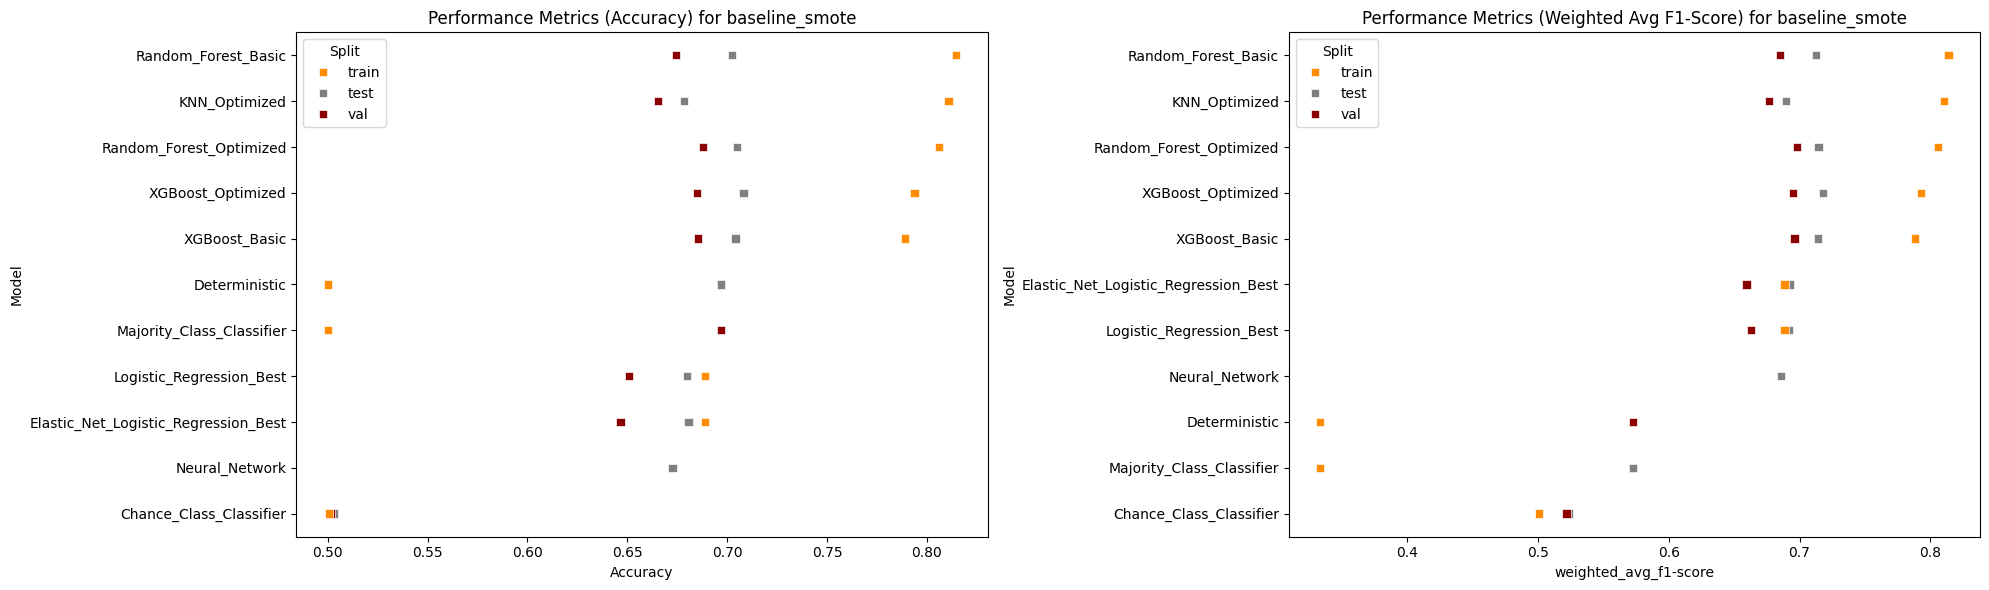

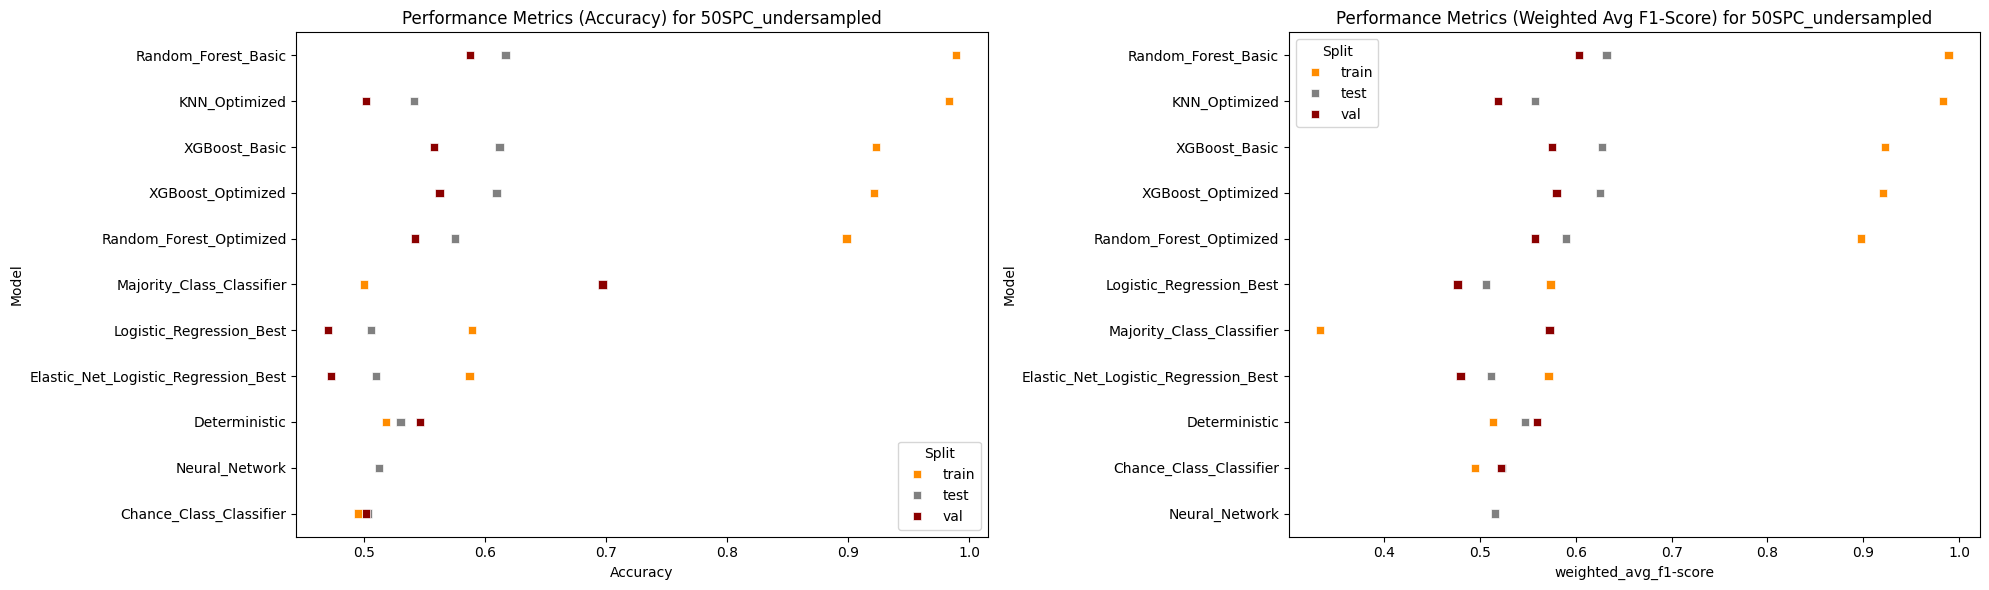

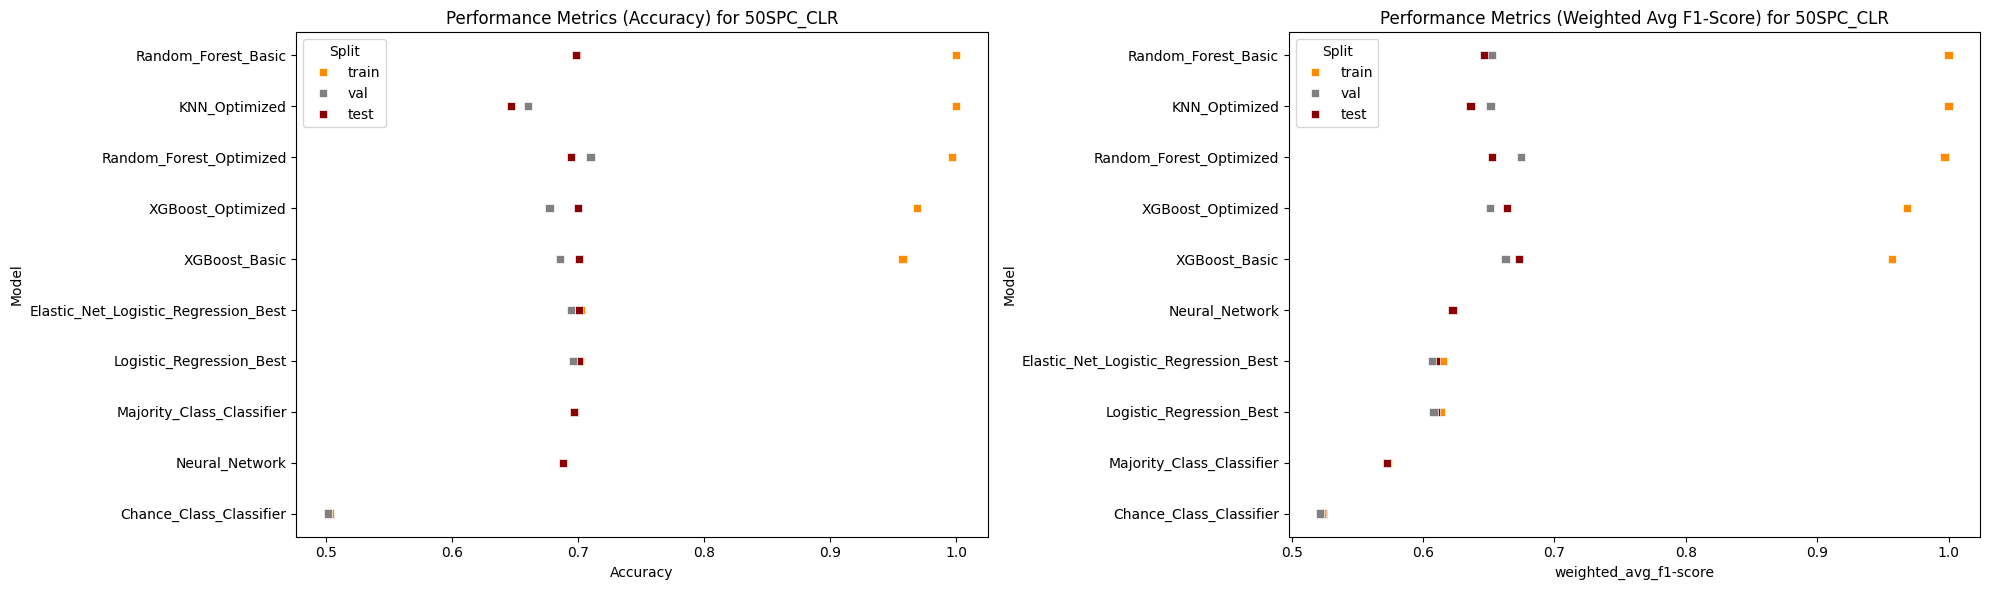

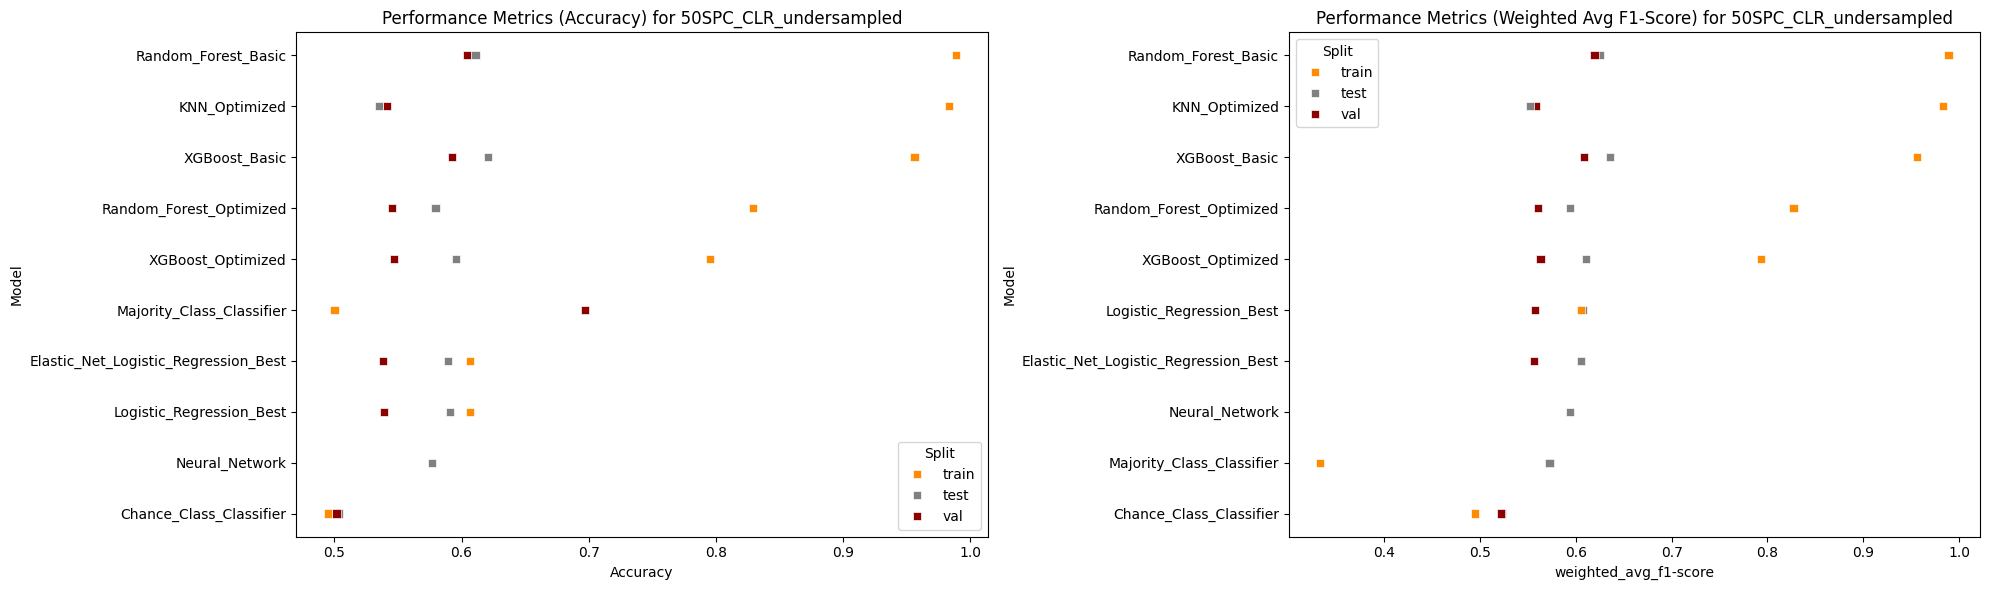

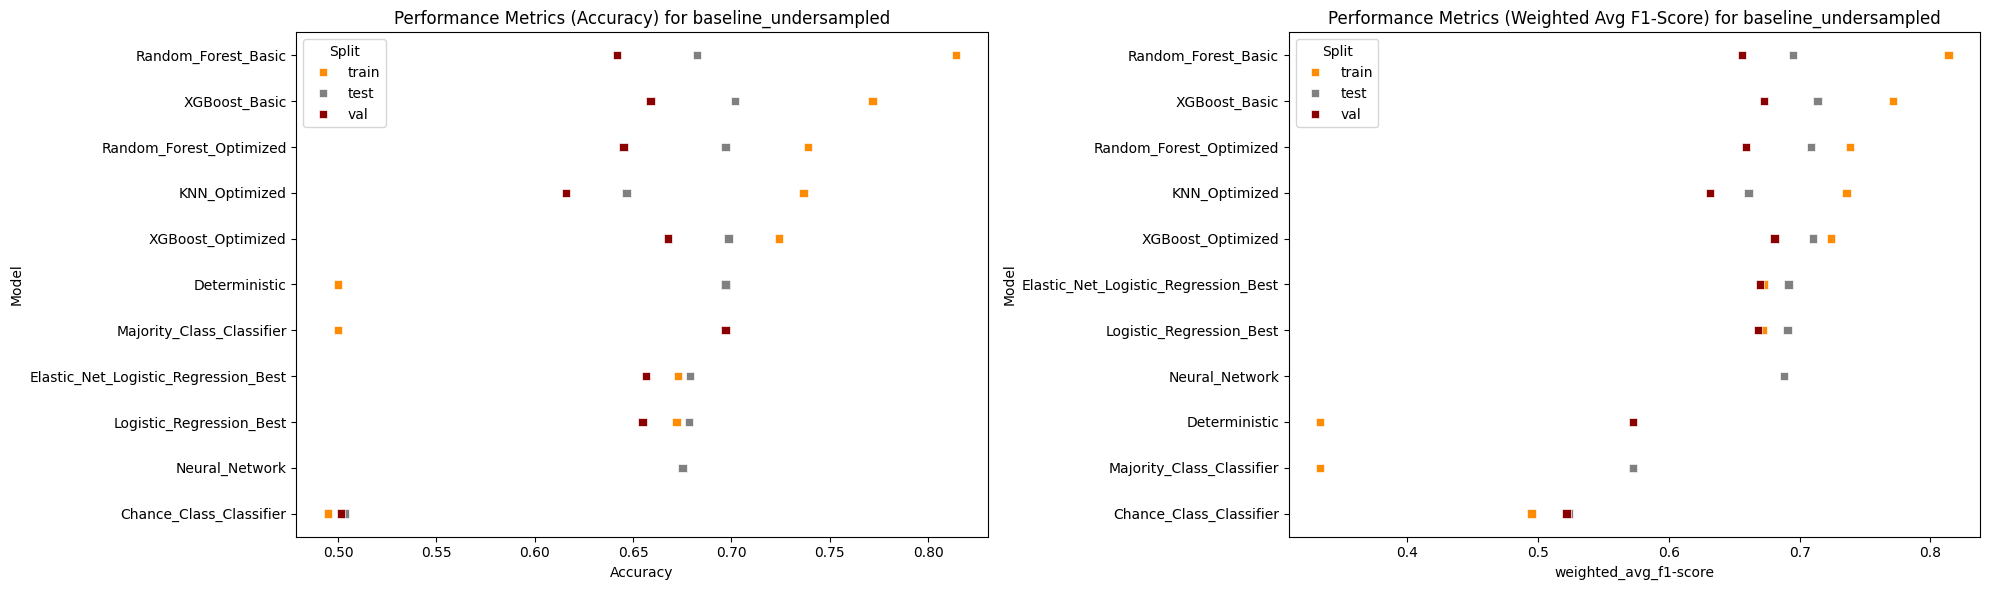

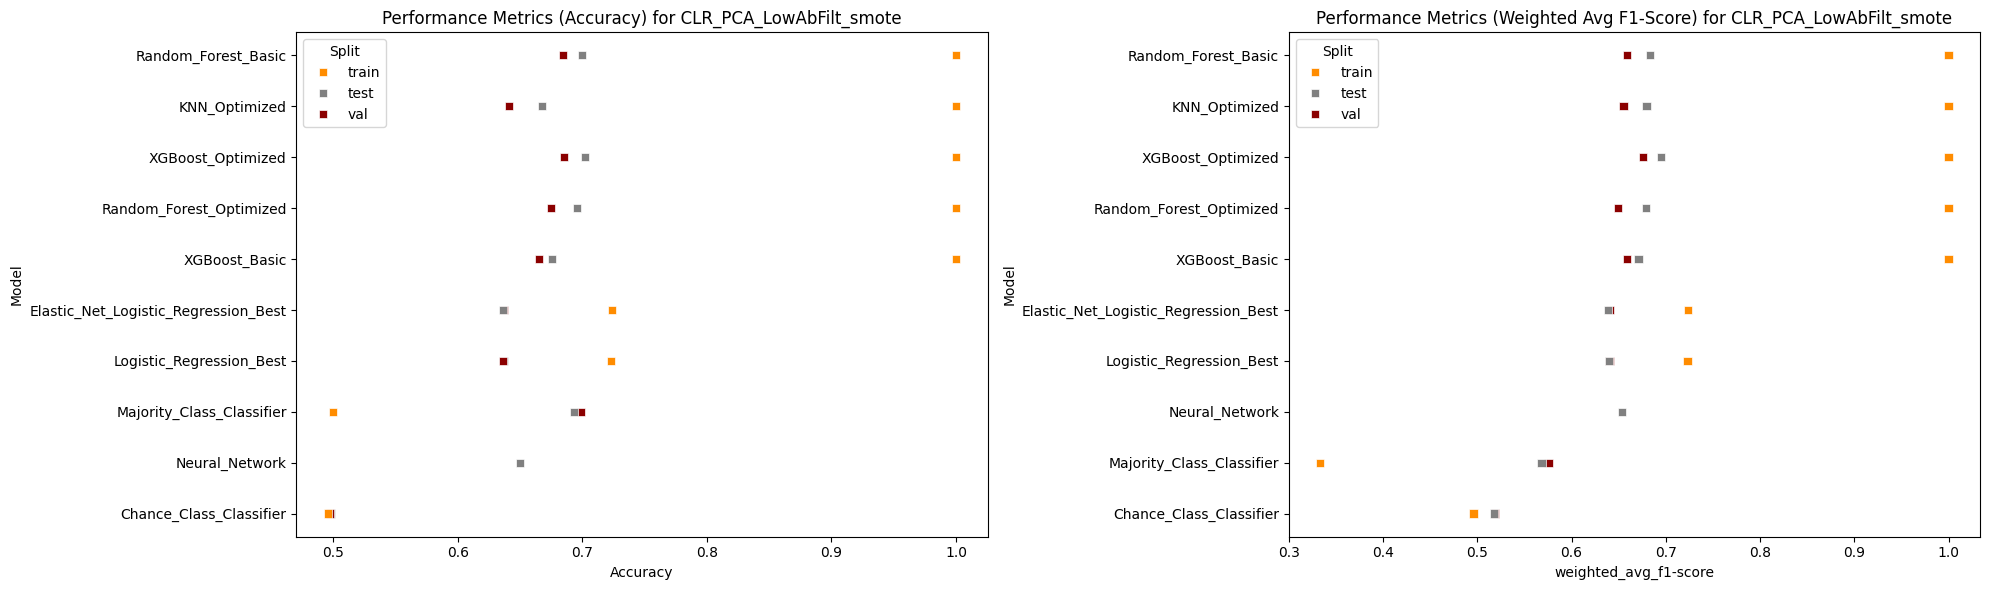

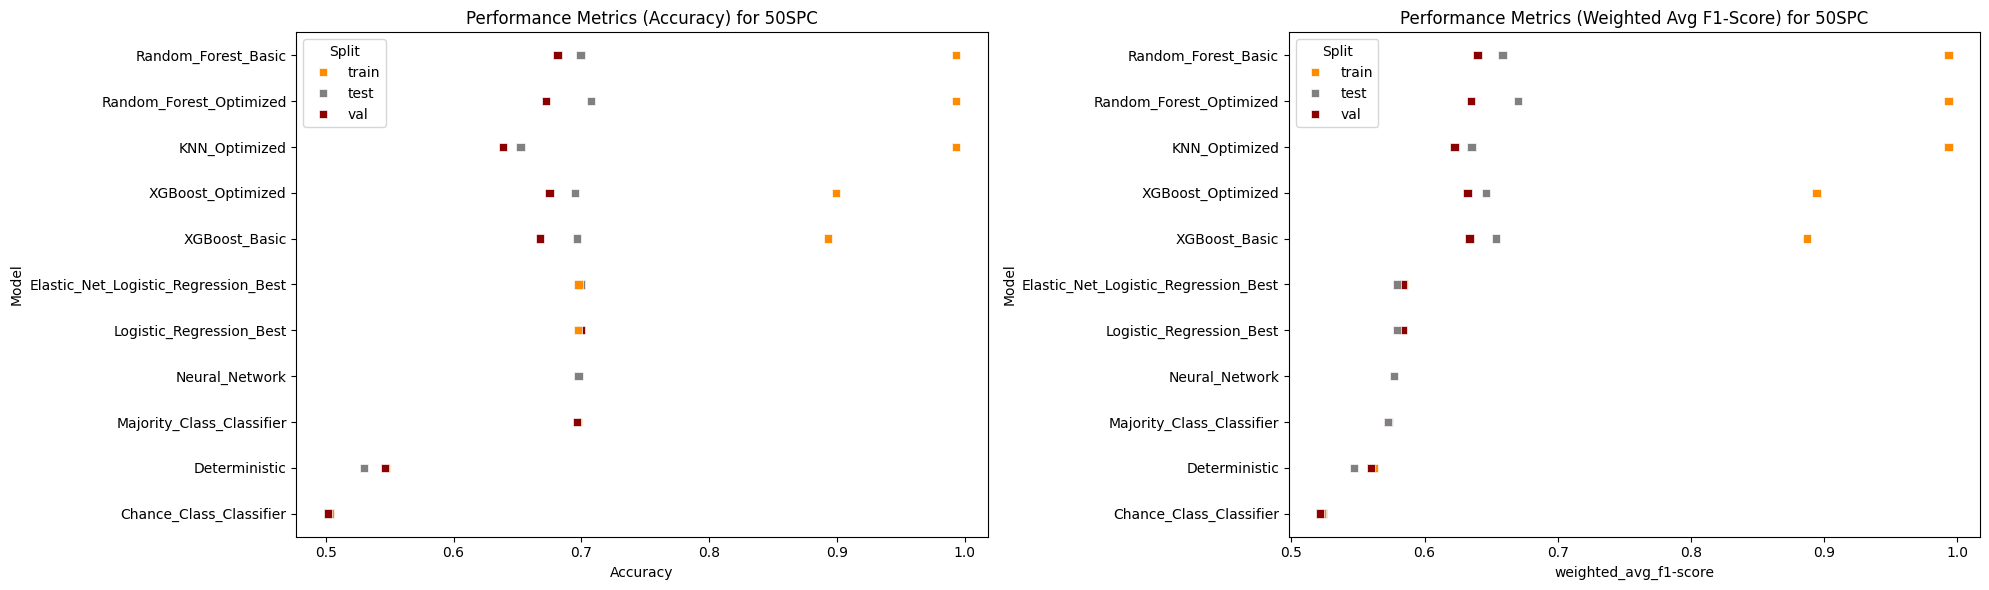

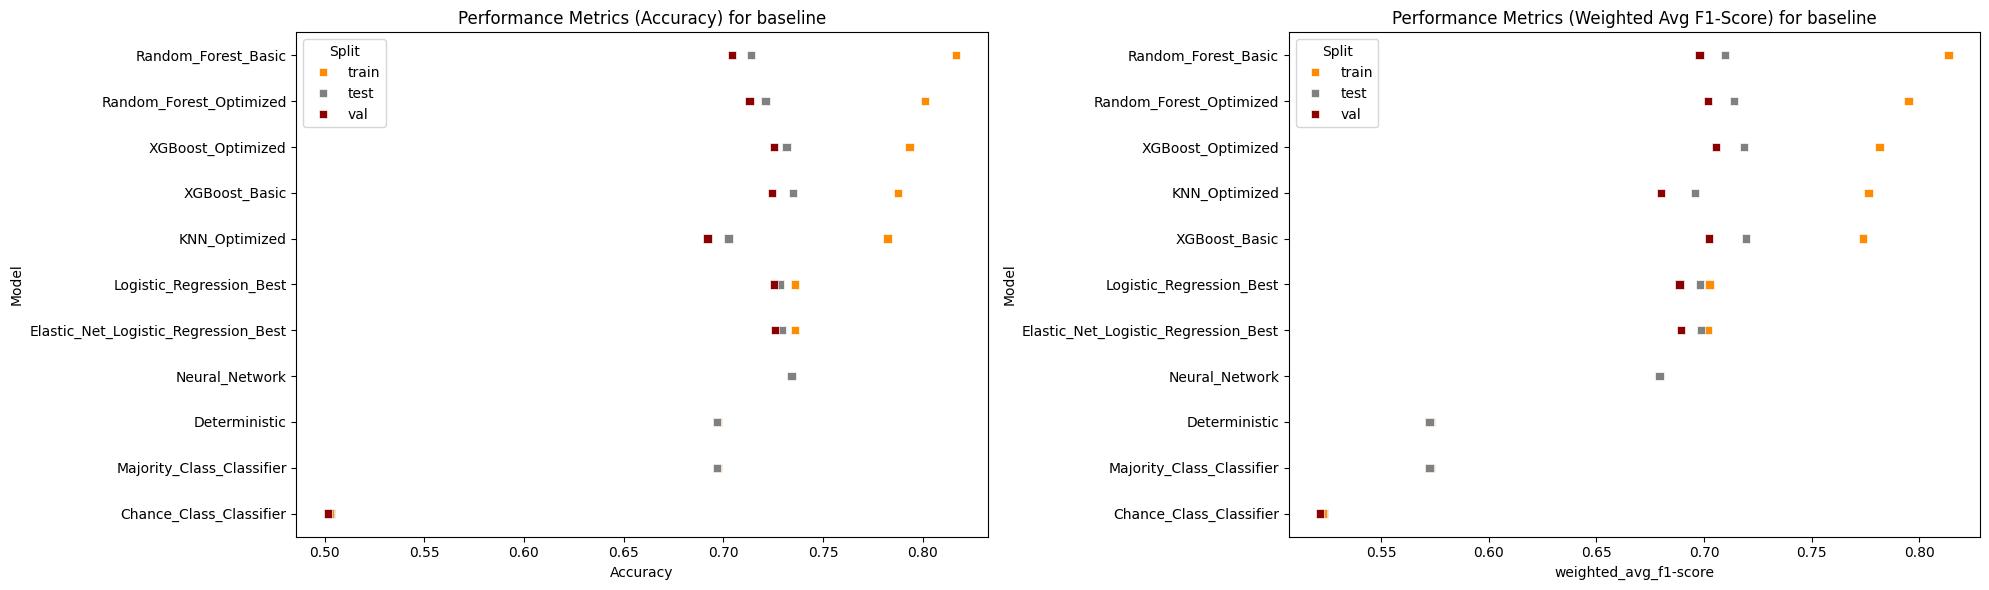

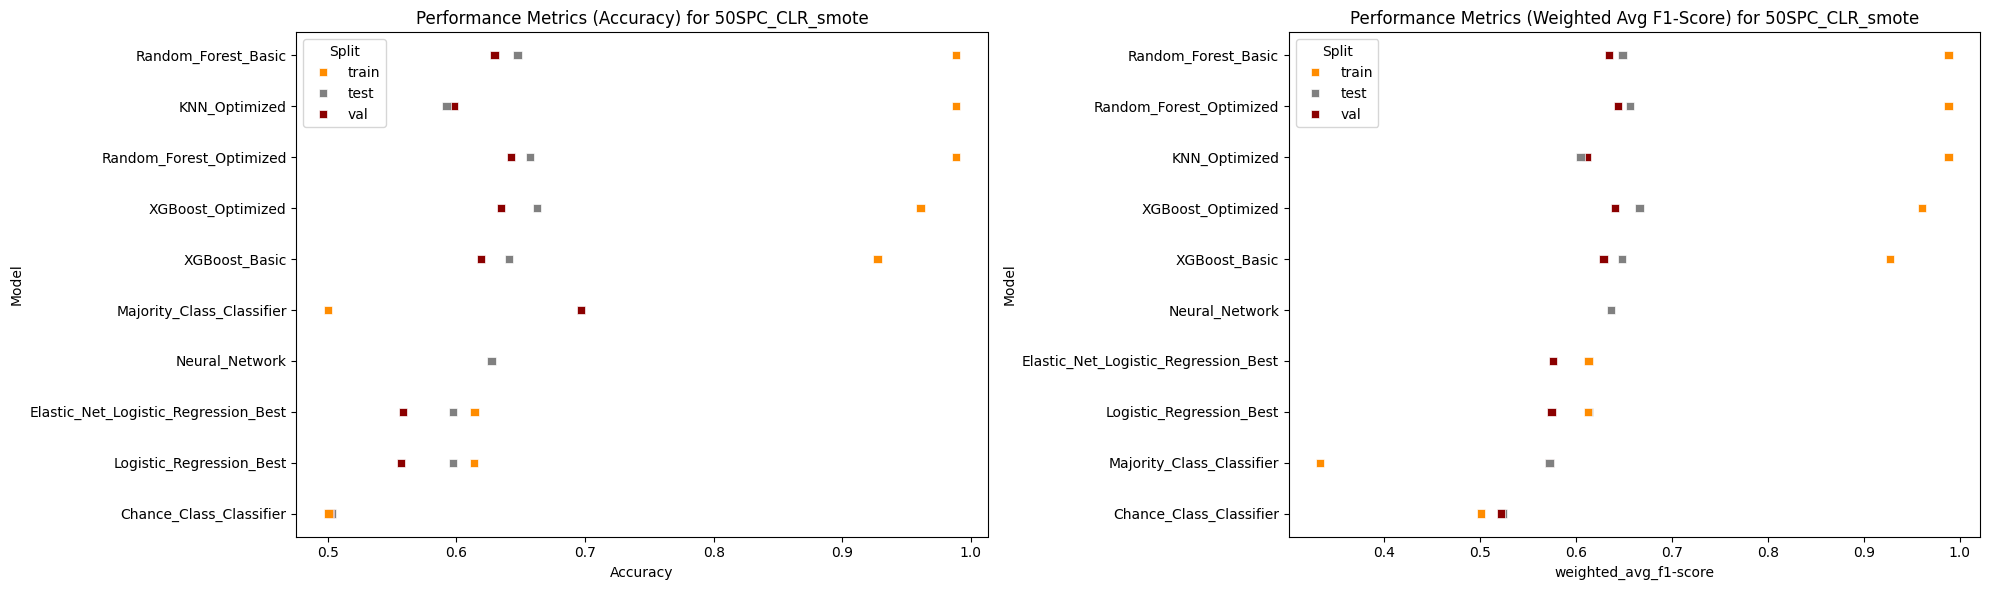

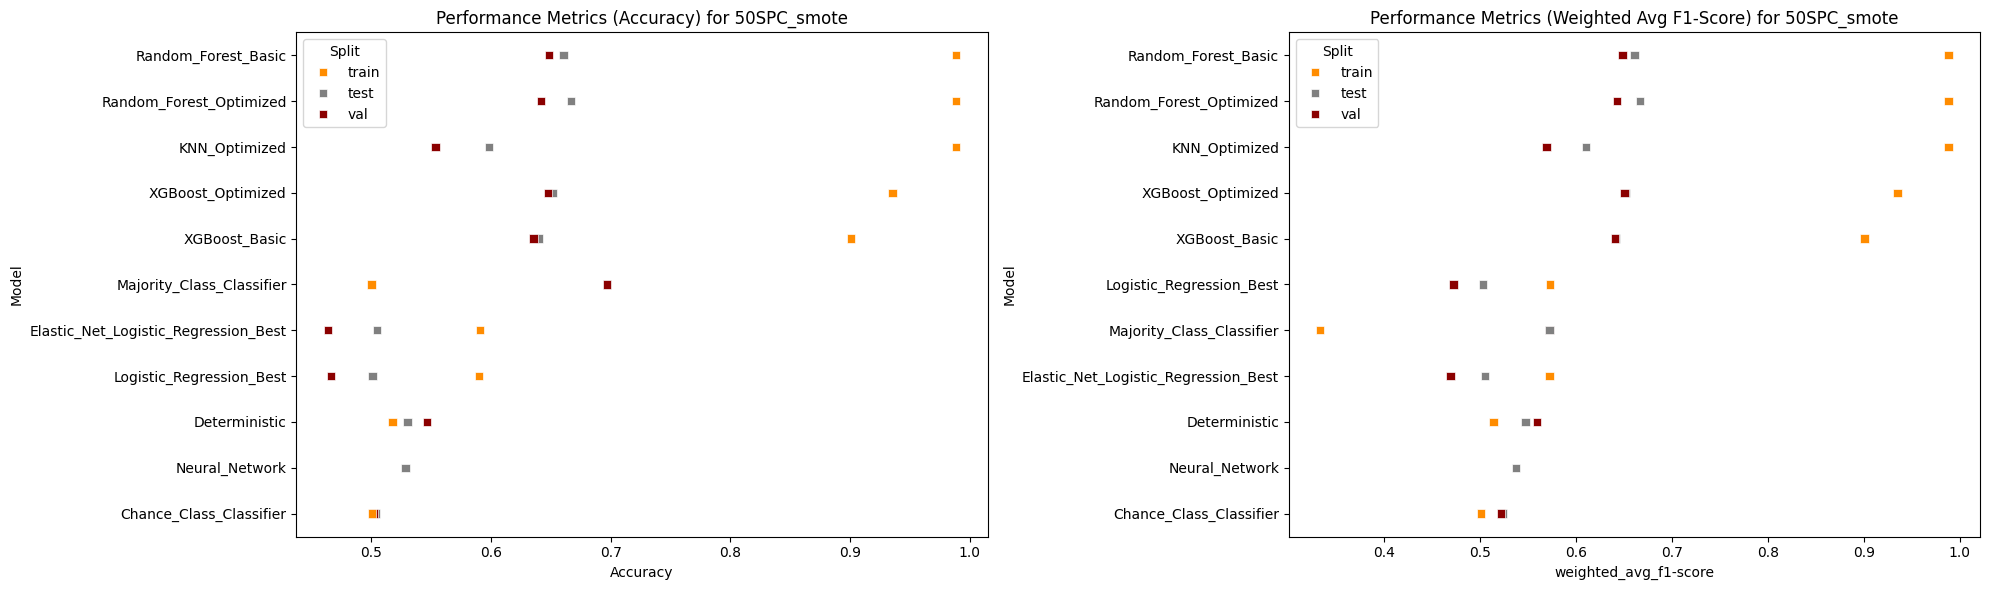

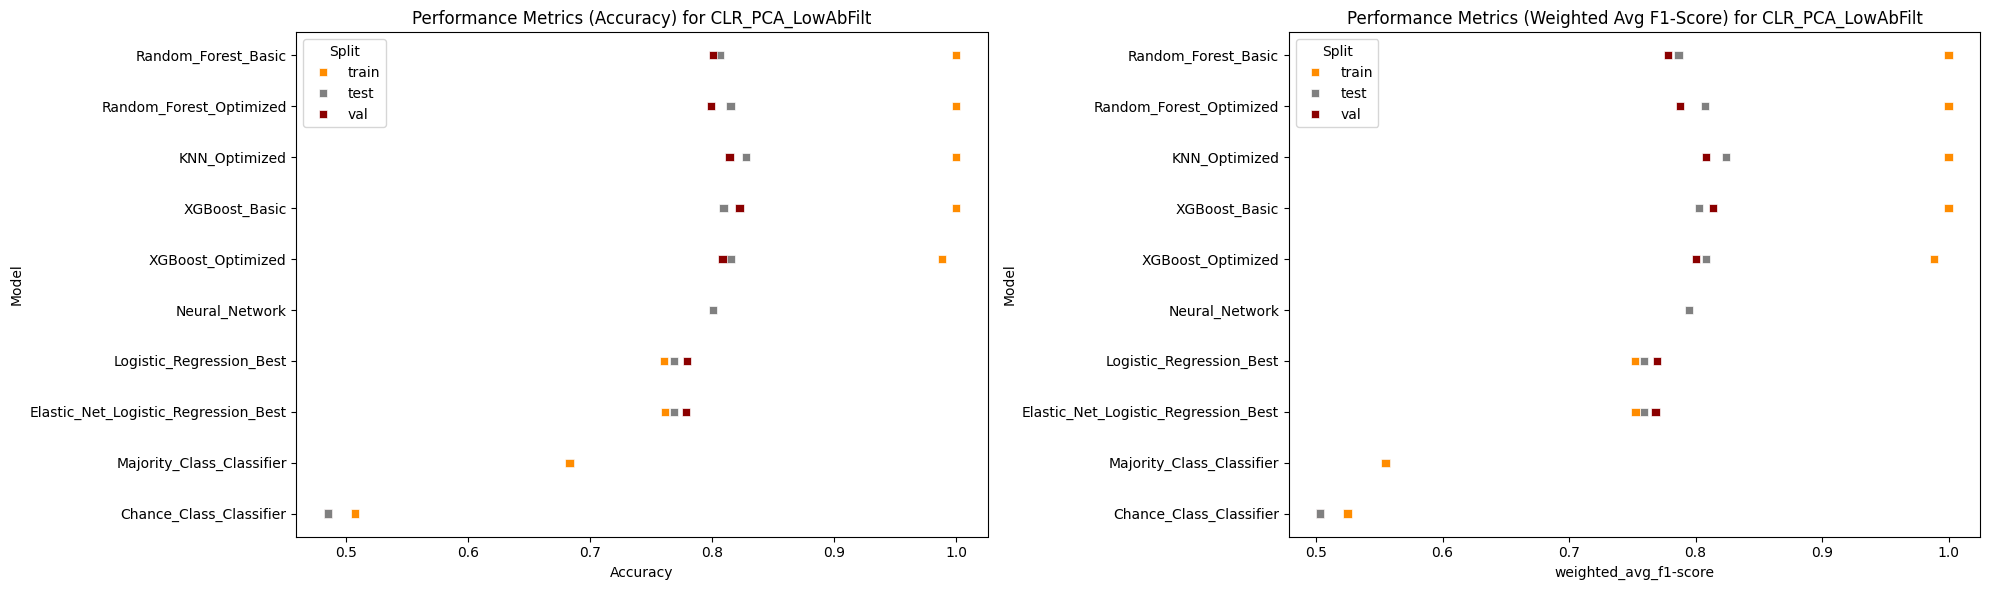

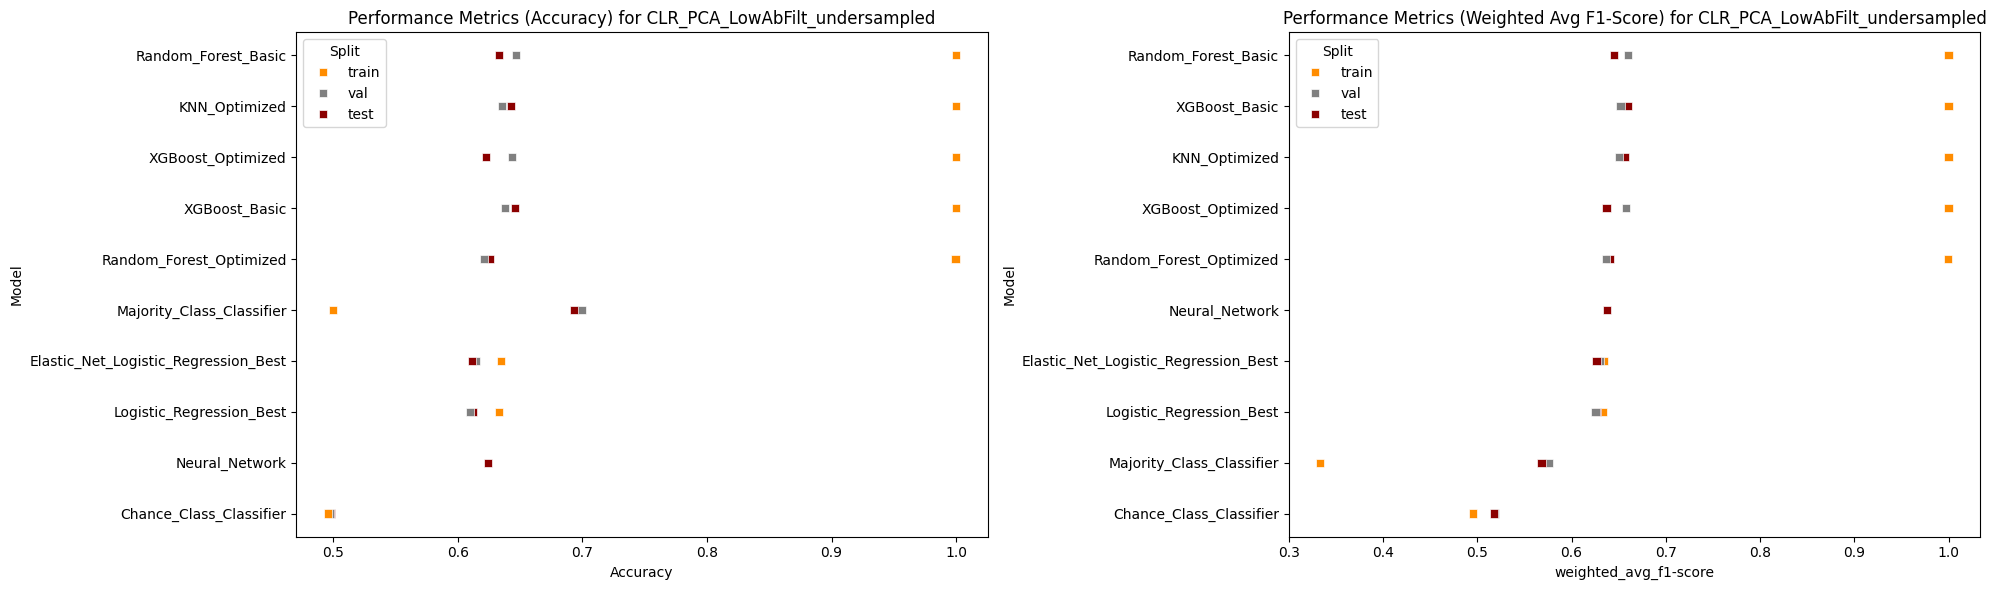

In [149]:
for directory in combined_df['Directory'].unique():
    # Filter the DataFrame for the current directory
    subset_df = combined_df[combined_df['Directory'] == directory]
    
    # Sort the DataFrame by 'Accuracy' for the first plot
    sorted_df_accuracy = subset_df.sort_values(by='Accuracy', ascending=False)
    
    # Sort the DataFrame by 'weighted_avg_f1-score' for the second plot
    sorted_df_f1 = subset_df.sort_values(by='weighted_avg_f1-score', ascending=False)
    
    # Create subplots with 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Create the scatter plot for Accuracy
    sns.scatterplot(ax=axes[0], data=sorted_df_accuracy, 
                    y='Model', 
                    x='Accuracy', 
                    marker='s', 
                    hue='Split', palette=['darkorange', 'grey', 'darkred'])
    
    # Set plot title for Accuracy
    axes[0].set_title(f'Performance Metrics (Accuracy) for {directory}')
    
    # Create the scatter plot for weighted_avg_f1-score
    sns.scatterplot(ax=axes[1], data=sorted_df_f1, 
                    y='Model', 
                    x='weighted_avg_f1-score', 
                    marker='s', 
                    hue='Split', palette=['darkorange', 'grey', 'darkred'])
    
    # Set plot title for weighted_avg_f1-score
    axes[1].set_title(f'Performance Metrics (Weighted Avg F1-Score) for {directory}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

